C:\Users\Zied\AppData\Local\Temp\ipykernel_11844\1668842478.py:36: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Zied\anaconda3\envs\eclipseguardian_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


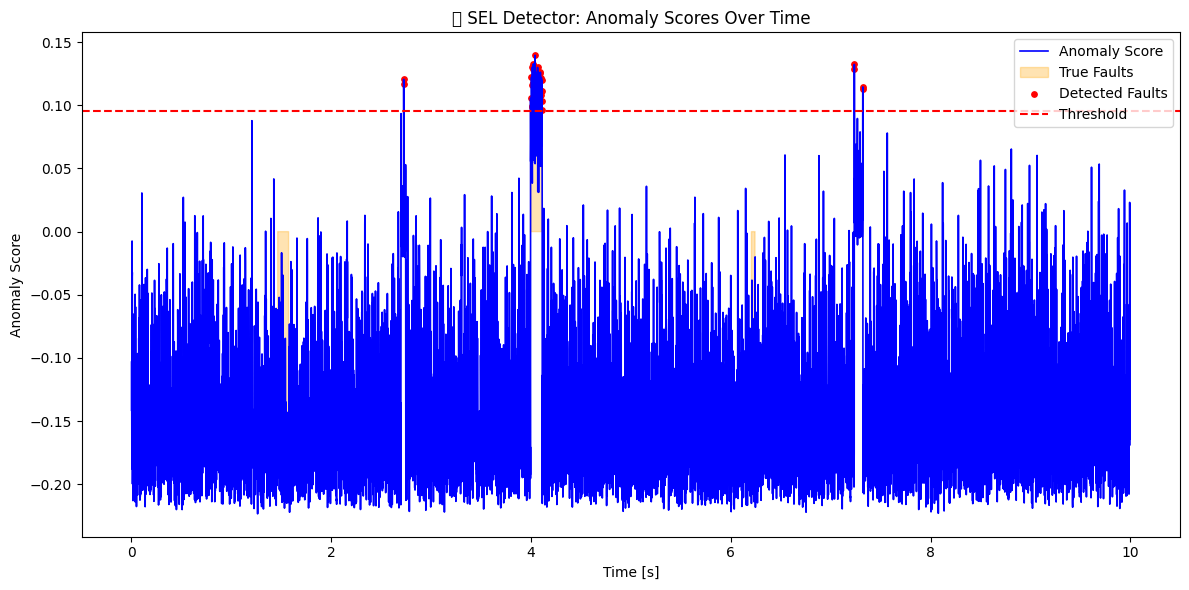

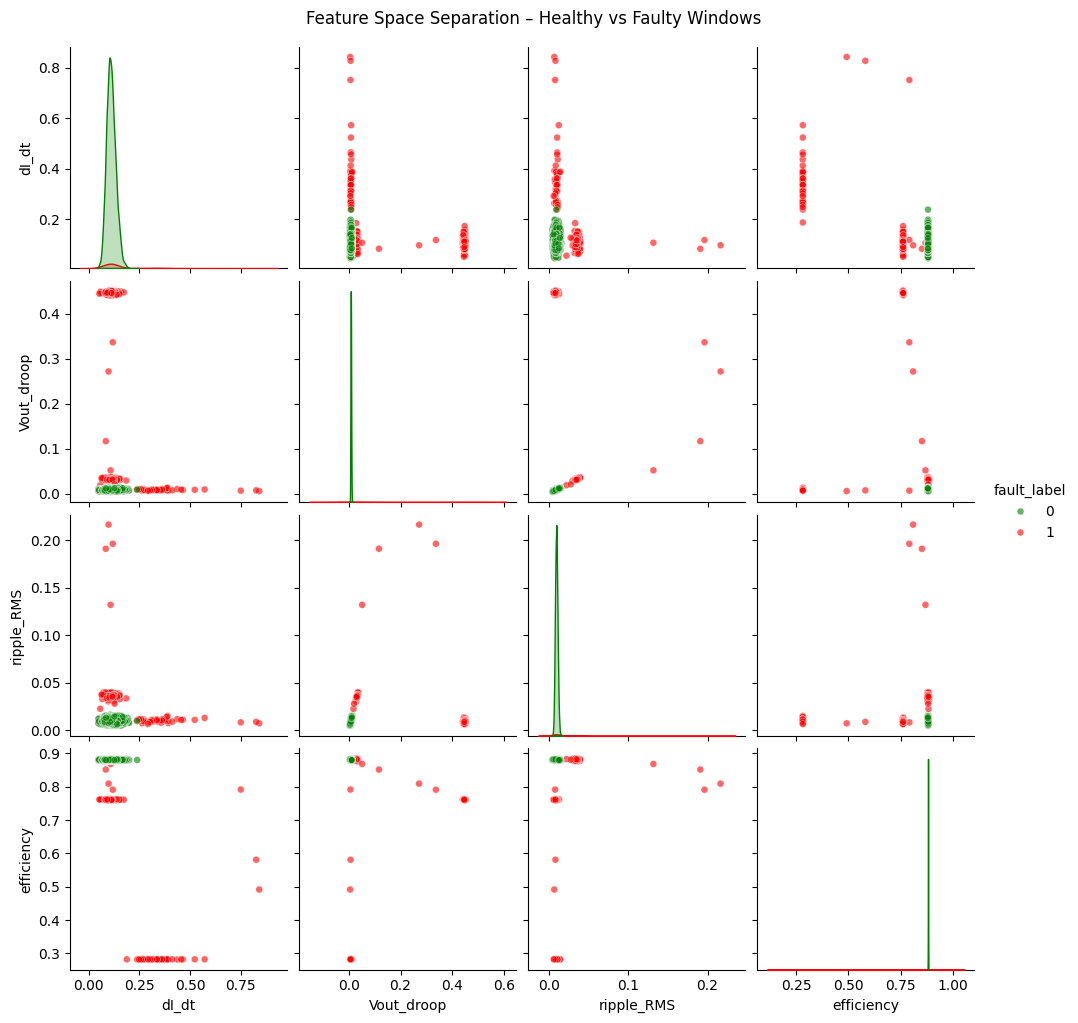

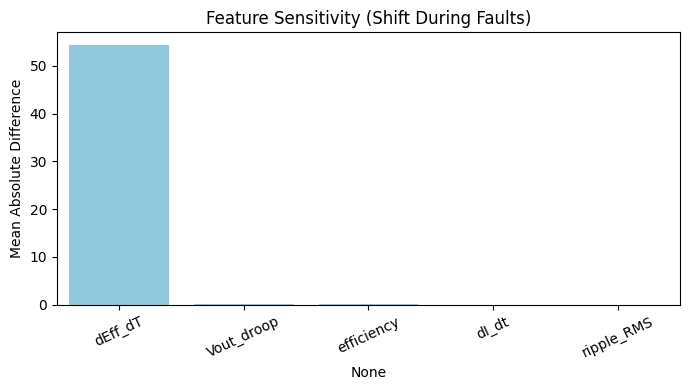

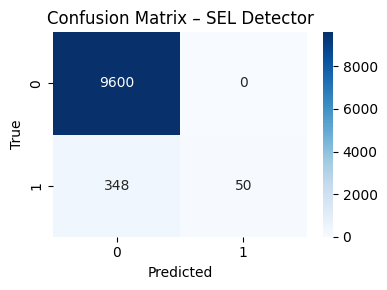

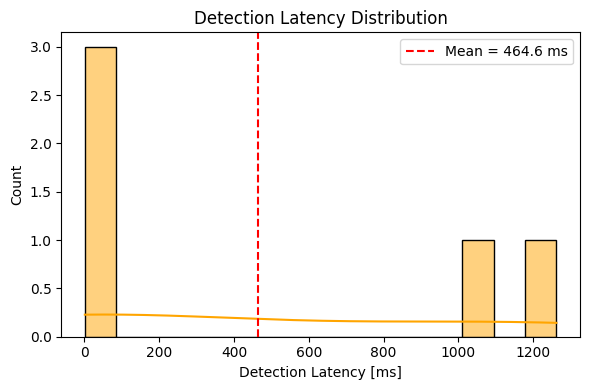

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the evaluated feature dataset (from Step 5)
df_feat = pd.read_csv("../data/cubesat_features.csv")

# Load the saved evaluation results (optional)
df_feat["anomaly_score"] = np.loadtxt("anomaly_scores.txt") if "anomaly_scores.txt" in locals() else df_feat.get("anomaly_score", 0)
if "predicted_fault" not in df_feat.columns:
    from sklearn.ensemble import IsolationForest
    import joblib
    iso = joblib.load("../models/iforest_model.pkl")
    scaler = joblib.load("../models/feature_scaler.pkl")
    X_scaled = scaler.transform(df_feat[["dI_dt","Vout_droop","ripple_RMS","efficiency","dEff_dT"]].values)
    df_feat["anomaly_score"] = -iso.decision_function(X_scaled)
    threshold = np.percentile(df_feat["anomaly_score"], 99.5)
    df_feat["predicted_fault"] = (df_feat["anomaly_score"] > threshold).astype(int)

# -----------------------------
# 1️⃣ Time-series overlay (score + true faults)
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_feat["time_s"], df_feat["anomaly_score"], color="blue", lw=1.2, label="Anomaly Score")
plt.fill_between(df_feat["time_s"], 0, df_feat["anomaly_score"],
                 where=df_feat["fault_label"]==1, color="orange", alpha=0.3, label="True Faults")
plt.scatter(df_feat.loc[df_feat["predicted_fault"]==1,"time_s"],
            df_feat.loc[df_feat["predicted_fault"]==1,"anomaly_score"],
            color="red", s=15, label="Detected Faults")
plt.axhline(y=df_feat["anomaly_score"].quantile(0.995), color="r", linestyle="--", label="Threshold")
plt.xlabel("Time [s]")
plt.ylabel("Anomaly Score")
plt.title("🛰️ SEL Detector: Anomaly Scores Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2️⃣ Feature relationships (pairplot)
# -----------------------------
sns.pairplot(df_feat,
             vars=["dI_dt","Vout_droop","ripple_RMS","efficiency"],
             hue="fault_label",
             palette={0:"green",1:"red"},
             plot_kws={"alpha":0.6, "s":25})
plt.suptitle("Feature Space Separation – Healthy vs Faulty Windows", y=1.02)
plt.show()

# -----------------------------
# 3️⃣ Feature importance proxy (mean |Z| per feature)
# -----------------------------
# Estimate which features shift most during anomalies
healthy_mean = df_feat[df_feat["fault_label"]==0][["dI_dt","Vout_droop","ripple_RMS","efficiency","dEff_dT"]].mean()
fault_mean = df_feat[df_feat["fault_label"]==1][["dI_dt","Vout_droop","ripple_RMS","efficiency","dEff_dT"]].mean()
diff = (fault_mean - healthy_mean).abs().sort_values(ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x=diff.index, y=diff.values, color="skyblue")
plt.title("Feature Sensitivity (Shift During Faults)")
plt.ylabel("Mean Absolute Difference")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# -----------------------------
# 4️⃣ Confusion matrix heatmap
# -----------------------------
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_feat["fault_label"], df_feat["predicted_fault"])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix – SEL Detector")
plt.tight_layout()
plt.show()

# -----------------------------
# 5️⃣ Detection latency distribution (optional)
# -----------------------------
fs = 10_000
window_ms = 2
time_step = window_ms/2/1000

y_true = df_feat["fault_label"].values
det_latencies = []
fault_starts = np.where(np.diff(y_true)==1)[0]

for s in fault_starts:
    after = np.where(df_feat.index > s)[0]
    idx_detect = None
    for i in after:
        if df_feat.loc[i,"predicted_fault"]==1:
            idx_detect = i; break
    if idx_detect:
        latency = (idx_detect - s) * time_step * 1000
        det_latencies.append(latency)

if det_latencies:
    plt.figure(figsize=(6,4))
    sns.histplot(det_latencies, bins=15, color="orange", kde=True)
    plt.axvline(np.mean(det_latencies), color="r", linestyle="--", label=f"Mean = {np.mean(det_latencies):.1f} ms")
    plt.xlabel("Detection Latency [ms]")
    plt.ylabel("Count")
    plt.title("Detection Latency Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()
